In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns

In [2]:

bsky_df = pd.read_csv('/Users/chloexc/Documents/Diffusion/data/bsky_reply_stats.csv')
ts_df = pd.read_csv('/Users/chloexc/Documents/Diffusion/data/ts_reply_stats.csv')

ts_df.rename(columns={'topic': 'topic_label'}, inplace=True)

In [3]:
# Select relevant columns
columns_to_keep = ['platform', 'topic_label', 'max_depth', 'size', 'breadth', 'index']  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
ts_df = ts_df[columns_to_keep].reset_index(drop=True)

df = pd.concat([bsky_df, ts_df], ignore_index=True)
df = df.dropna(subset=['topic_label'])

metrics = ['max_depth', 'size', 'breadth']  # Removed 'structural_virality'


In [24]:
# Merge similar topics
df['topic_label'] = df['topic_label'].replace({
    "MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"
})

In [29]:
# Drop specified topic
df = df[df['topic_label'] != "Criticism of Trump and Support for Democratic Policies"]

## 1. general cross-platform comparison

In [4]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df['platform'] == 'bsky'][metric].dropna()
    ts_vals = df[df['platform'] == 'ts'][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({'Metric': metric, 'KS Statistic': ks_stat, 'P-value': p_value})

ks_overall_df = pd.DataFrame(ks_results)


In [5]:
# Function to compute CCDF
def empirical_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

In [6]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted(df['topic_label'].unique()))))  # Use tab20 colormap
sorted_topics = sorted(df['topic_label'].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}

def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data['topic_label'] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(sorted_vals, ccdf_vals, label=f'{topic}', linewidth=2, color=topic_color_map[topic])
    ax.set_xscale('log')  # Apply log scale to x-axis
    ax.set_yscale('log')
    ax.set_xlabel(metric)
    ax.set_ylabel('CCDF (%)')
    ax.set_title(f'CCDF of {metric} by Topic')
    ax.grid()


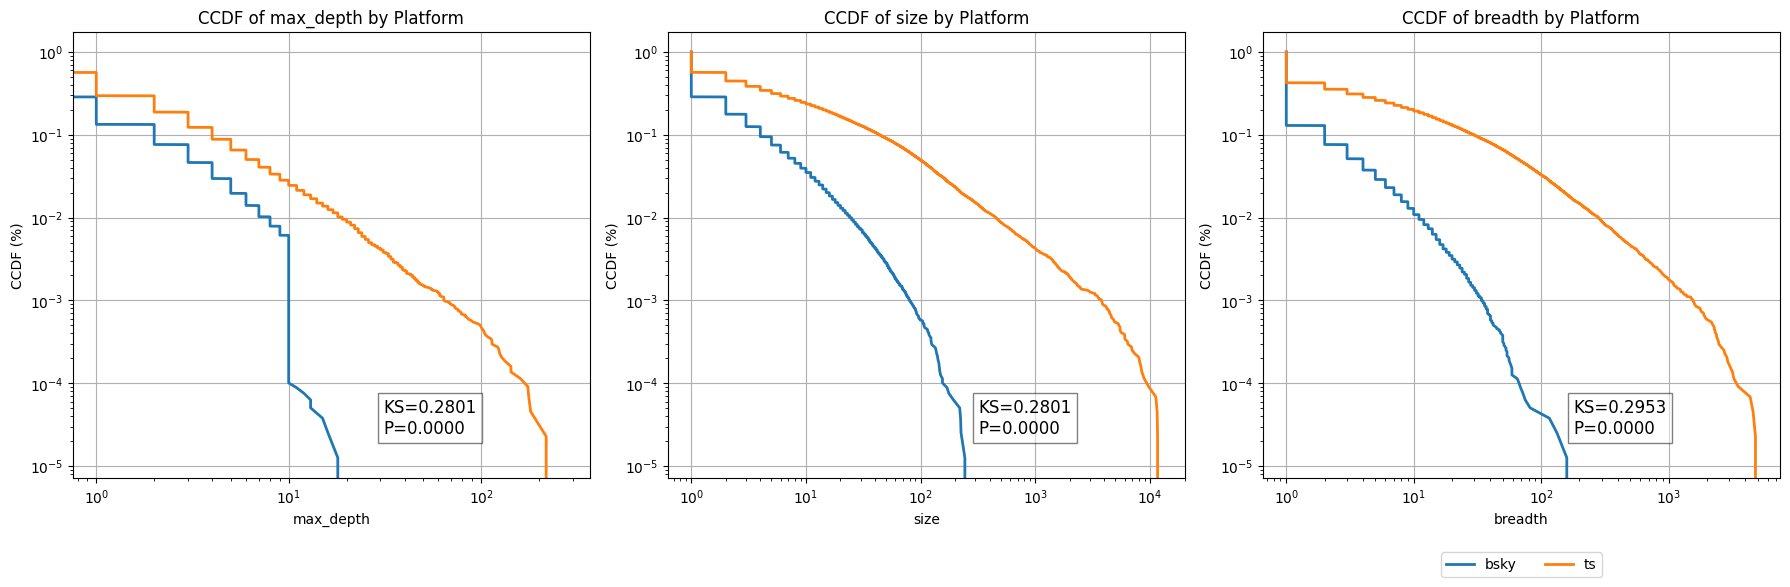

In [30]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ['bsky', 'ts']:
        values = df[df['platform'] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f'{platform}', linewidth=2)
    
    axes[idx].set_xscale('log')  # Apply log scale to x-axis
    axes[idx].set_yscale('log')  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel('CCDF (%)')
    axes[idx].set_title(f'CCDF of {metric} by Platform')
    axes[idx].grid()
    
    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[ks_overall_df['Metric'] == metric, ['KS Statistic', 'P-value']].values[0]
    axes[idx].text(0.6, 0.1, f'KS={ks_stat:.4f}\nP={p_value:.4f}', transform=axes[idx].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)  # Move legend outside
plt.tight_layout()
plt.show()

## 2. general cross-topic comparison

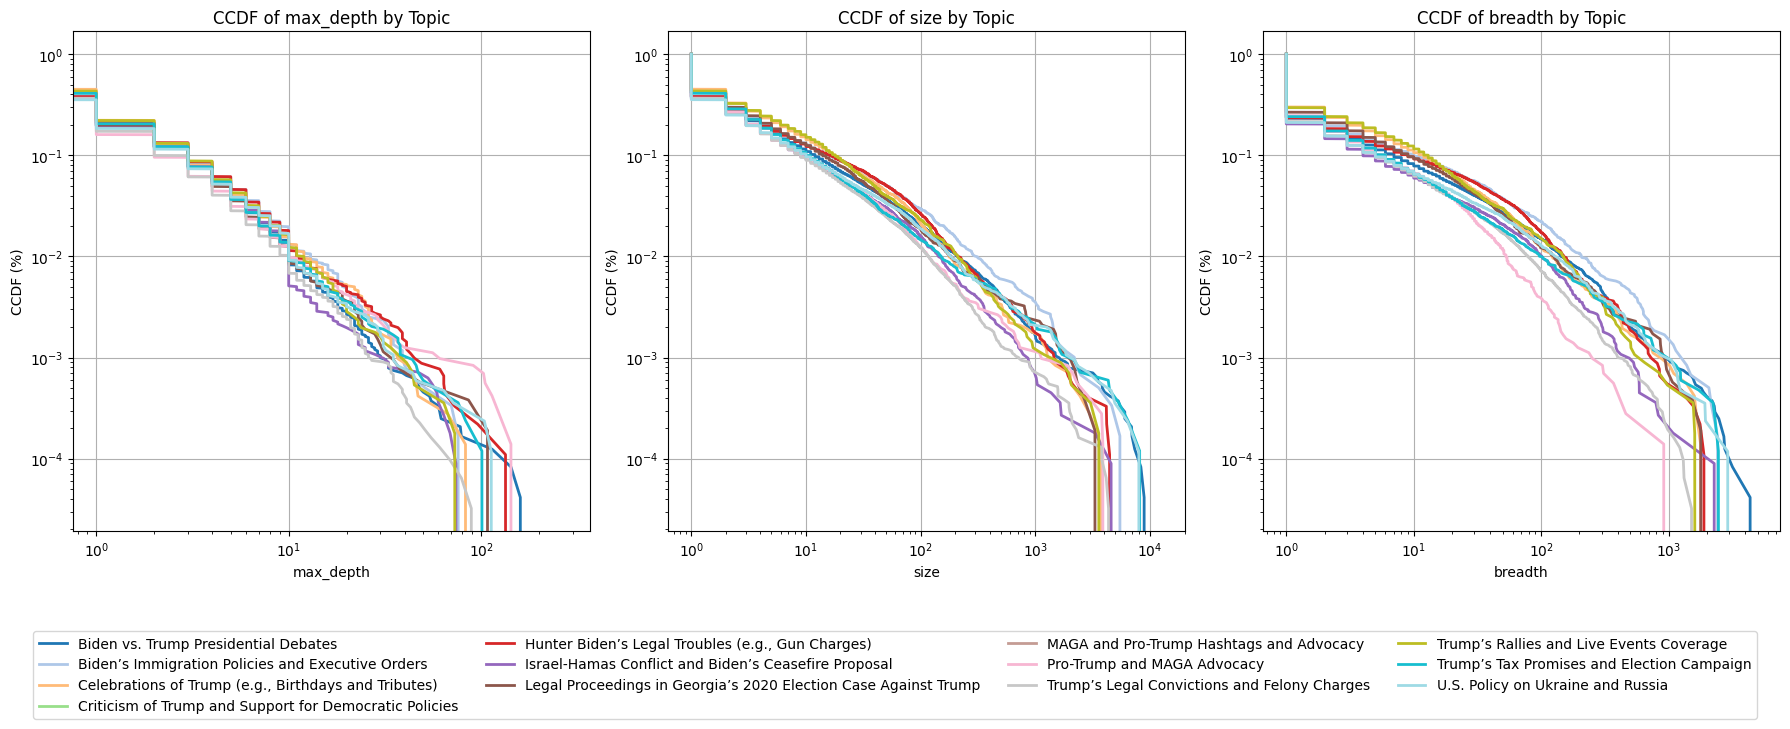

In [31]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)  # One legend outside

plt.tight_layout()
plt.show()


## 3. comparison by platform & by topic

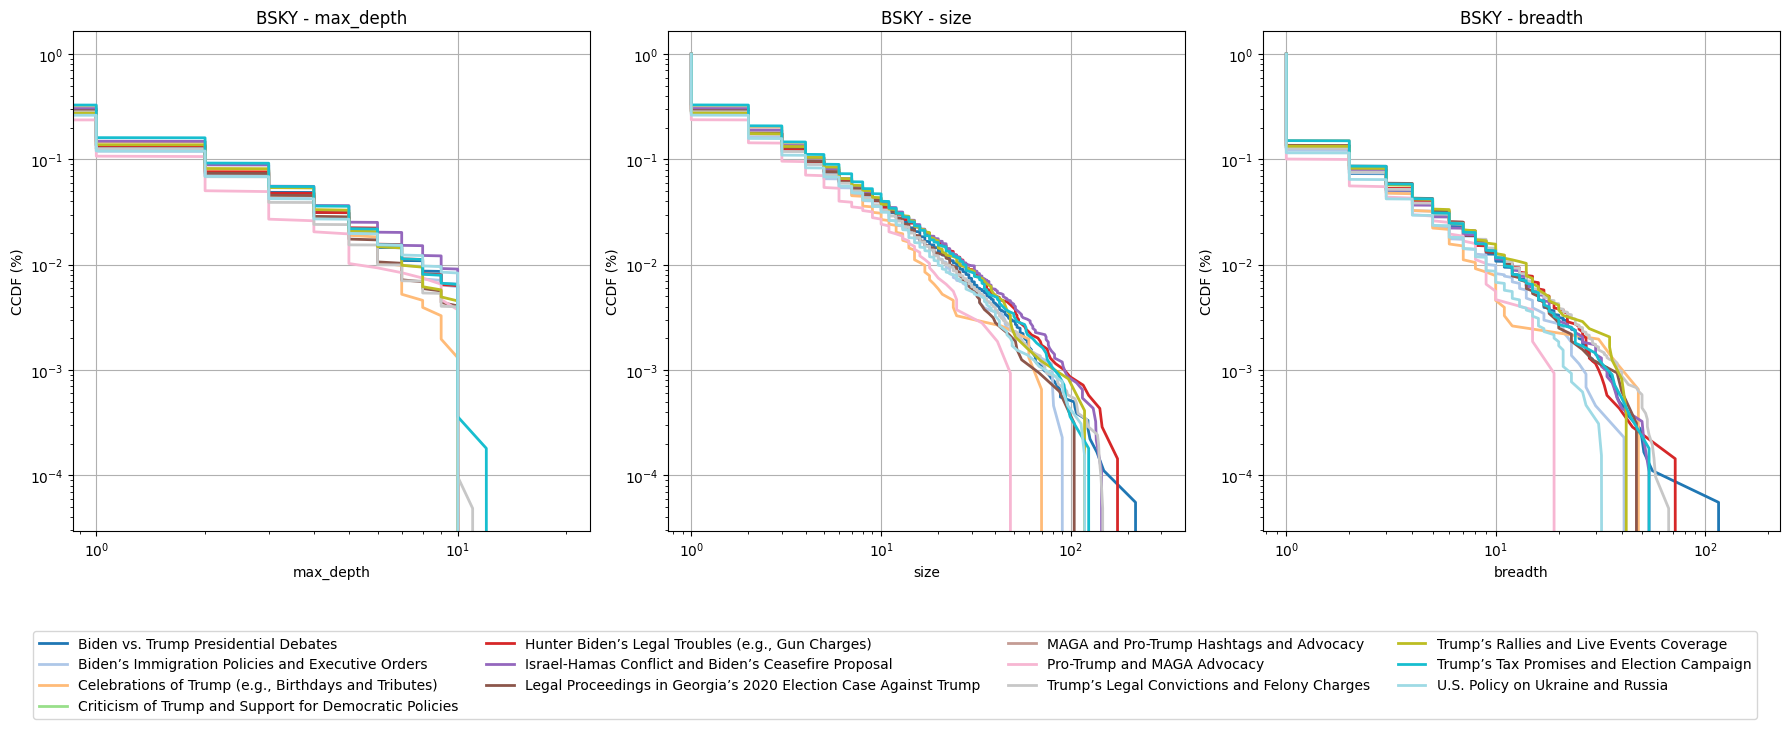

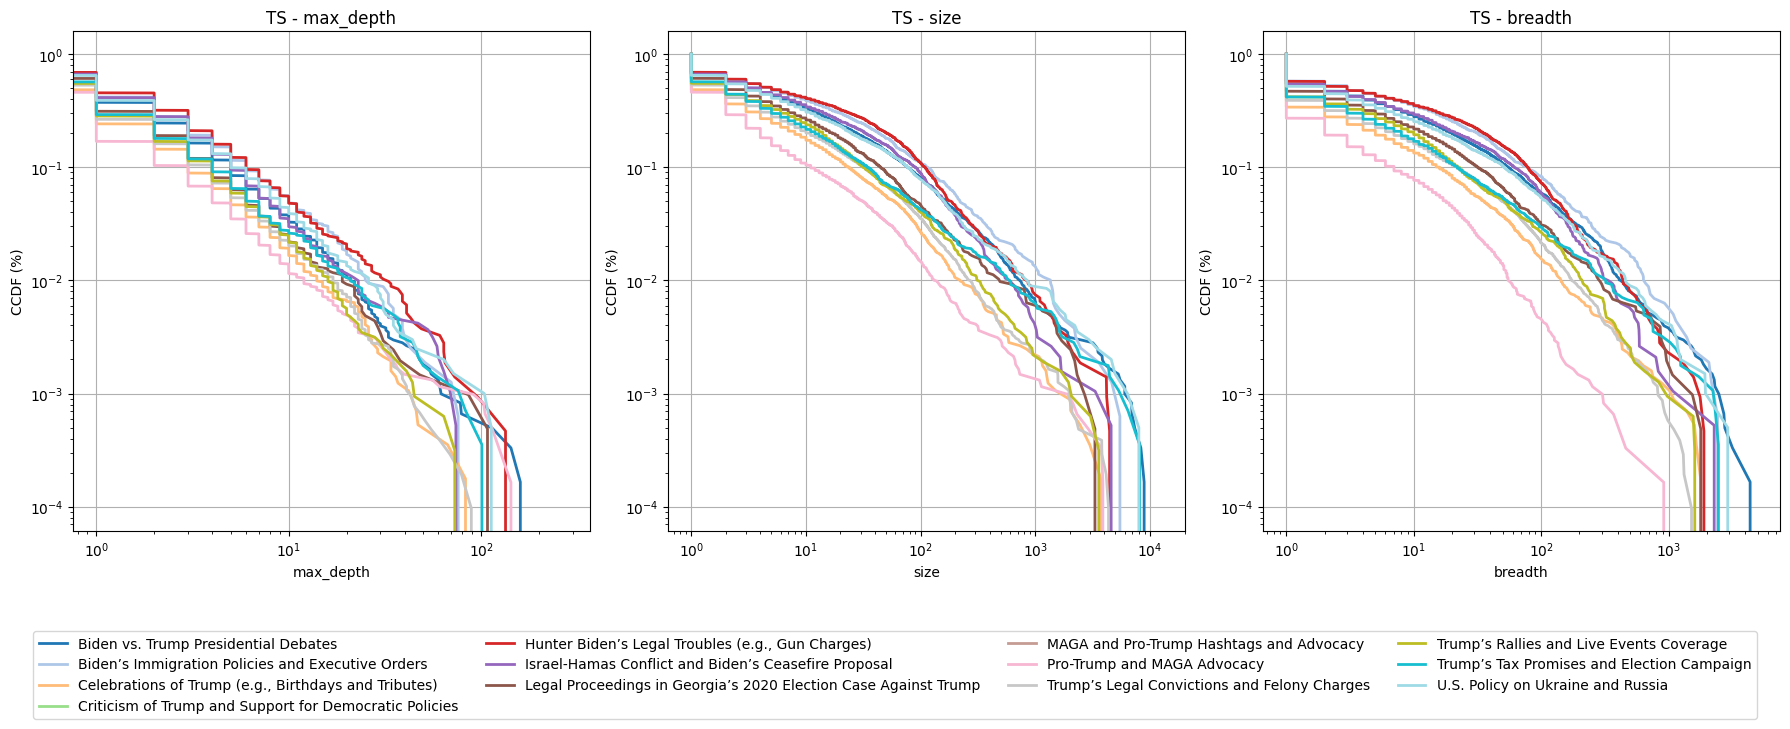

In [32]:
# Comparison by platform & by topic
for platform in ['bsky', 'ts']:
    platform_data = df[df['platform'] == platform]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f'{platform.upper()} - {metric}')
    
    handles, labels = zip(*sorted(zip(axes[0].get_legend_handles_labels()[0], axes[0].get_legend_handles_labels()[1]), key=lambda x: sorted_topics.index(x[1])))
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    plt.tight_layout()
    plt.show()


## 4. Investigate number of root posts under different topics on 2 platforms

/var/folders/_b/660kkhrj1_scxnln2hw1713w0000gn/T/ipykernel_31201/96867800.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=root_post_counts.values, y=root_post_counts.index, ax=axes[idx], palette='tab20')
/var/folders/_b/660kkhrj1_scxnln2hw1713w0000gn/T/ipykernel_31201/96867800.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=root_post_counts.values, y=root_post_counts.index, ax=axes[idx], palette='tab20')


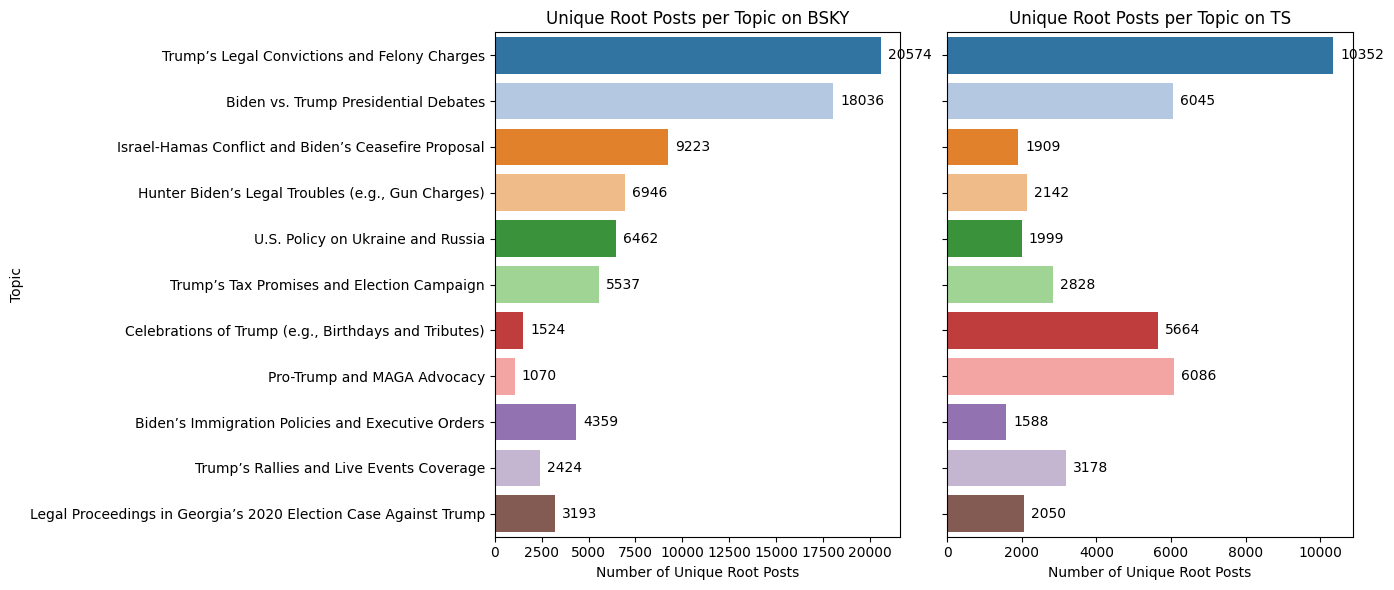

In [33]:
# Ensure consistent order of topics across both platforms
topic_order = df.groupby('topic_label')['index'].nunique().sort_values(ascending=False).index

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ['bsky', 'ts']

for idx, platform in enumerate(platforms):
    platform_data = df[df['platform'] == platform]
    root_post_counts = platform_data.groupby('topic_label')['index'].nunique().reindex(topic_order)
    
    sns.barplot(x=root_post_counts.values, y=root_post_counts.index, ax=axes[idx], palette='tab20')
    axes[idx].set_title(f'Unique Root Posts per Topic on {platform.upper()}')
    axes[idx].set_xlabel('Number of Unique Root Posts')
    axes[idx].set_ylabel('Topic')
    
    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(zip(root_post_counts.values, root_post_counts.index)):
        axes[idx].annotate(f'{value}', xy=(value, j), xytext=(5, 0), textcoords='offset points', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

## 5. Quantify the difference